# Exploring Mental Health processed data EDA 

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

sns.set_style("darkgrid")


In [34]:
train_path = "../data/processed/processed_train.csv"
val_path = "../data/processed/processed_val.csv"
test_path = "../data/processed/processed_test.csv"

train = pd.read_csv(train_path)
val = pd.read_csv(val_path)
test = pd.read_csv(test_path)

In [35]:
train.describe()

,Gender_Female,Gender_Male,Working Professional or Student_Student,Working Professional or Student_Working Professional,Sleep Duration_5-6 hours,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Sleep Duration_other,Dietary Habits_Healthy,...,Family History of Mental Illness_No,Family History of Mental Illness_Yes,id,Age,CGPA,Work/Study Hours,Financial Stress,Pressure,Satisfaction,Depression
count,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000,...,112560.000000,112560.000000,112560.000000,112560.000000,22297.000000,112560.000000,112560.000000,112560.000000,112560.000000,112560.000000
mean,0.449956,0.550044,0.198108,0.801892,0.228296,0.263993,0.274458,0.232694,0.000560,0.318648,...,0.501608,0.498392,70350.737198,40.398765,7.657597,6.247708,2.988451,3.027683,2.965352,0.181716
std,0.497491,0.497491,0.398576,0.398576,0.419736,0.440797,0.446243,0.422550,0.023651,0.465954,...,0.500000,0.500000,40604.292649,12.385130,1.463312,3.856462,1.413023,1.402264,1.404306,0.385612
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,18.000000,5.030000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,35209.750000,29.000000,6.290000,3.000000,2.000000,2.000000,2.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,70343.500000,42.000000,7.770000,6.000000,3.000000,3.000000,3.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,105562.750000,51.000000,8.920000,10.000000,4.000000,4.000000,4.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,140699.000000,60.000000,10.000000,12.000000,5.000000,5.000000,5.000000,1.000000


## Data Overview

<Figure size 1000x600 with 0 Axes>

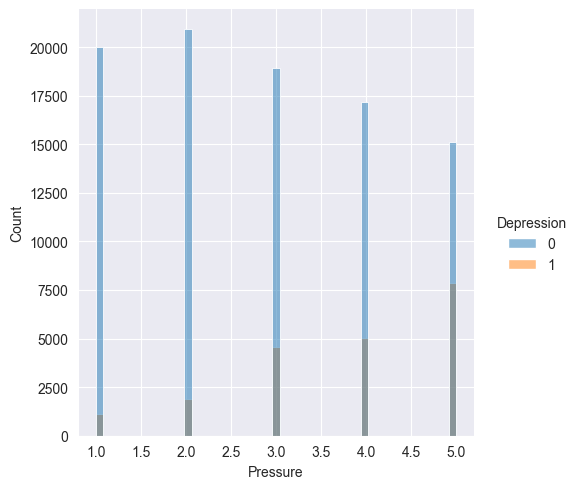

<Figure size 1000x600 with 0 Axes>

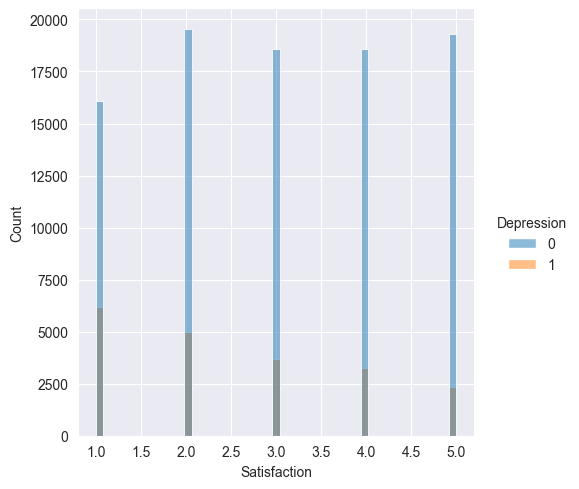

In [ ]:
sns.displot(train, x="Pressure", hue="Depression")
sns.displot(train, x="Satisfaction", hue="Depression")

<Axes: xlabel='Depression', ylabel='Pressure'>

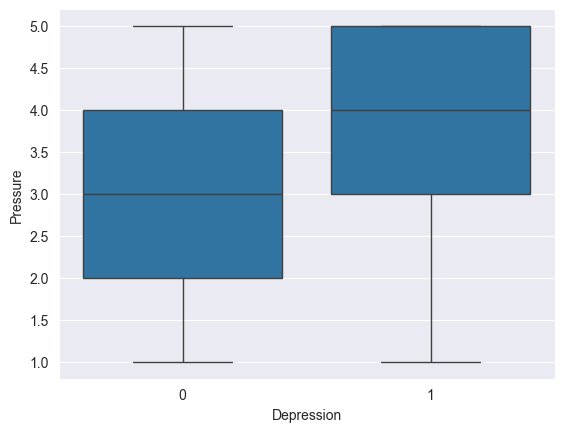

In [ ]:
sns.boxplot(train, x="Depression", y="Pressure")

<Axes: xlabel='Depression', ylabel='Satisfaction'>

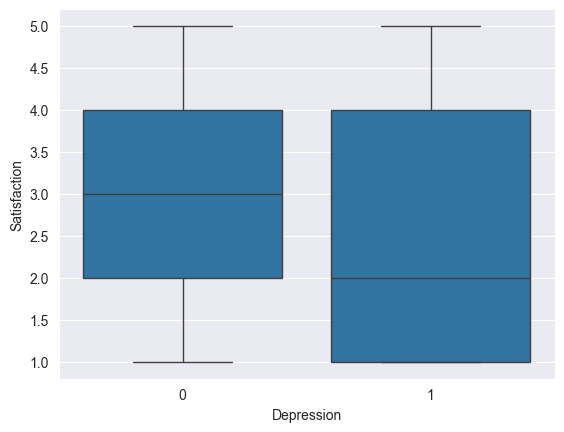

In [38]:
sns.boxplot(train, x="Depression", y="Satisfaction")

### Key Insights
- **Pressure**: Positive correlation with depression
- **Satisfaction**: Negative correlation with depression  

### Visual Findings
- Pressure levels are significantly higher for depressed individuals
- Satisfaction scores are markedly lower for depressed group

### Correlation

<Axes: title={'center': 'Correlation with Depression'}>

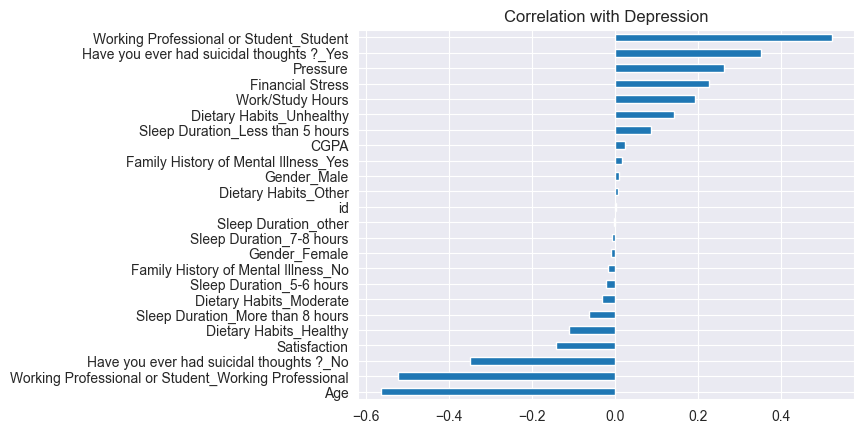

In [39]:
X_train = train.copy()
y_train = X_train.pop("Depression")
corr = X_train.corrwith(y_train).sort_values()
corr.plot.barh(title="Correlation with Depression")

### Key Insights
**Age**, **Working Professional or Student**, **Have you ever had Suicidal thoughts**, **Pressure**, **Satisfaction**, **Work/Study Hours** are the features that are the more correlated with depression.

### Quality of life features 

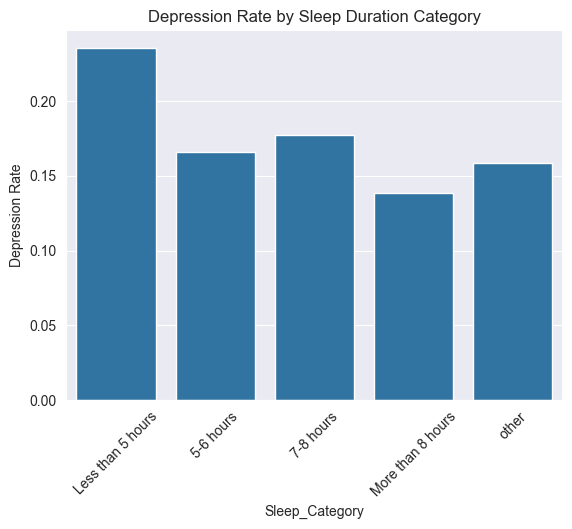

In [40]:
# Get all sleep duration columns
sleep_cols = [col for col in X_train.columns if col.startswith("Sleep Duration_")]

# Calculate depression rate as: (depressed cases in category) / (total in category)
sleep_depression = pd.DataFrame({
    "Sleep_Category": [col.replace("Sleep Duration_", "") for col in sleep_cols],
    "Depression_Rate": [train[train[col] == 1]["Depression"].mean() for col in sleep_cols]
})

# Sort categories logically
category_order = ["Less than 5 hours", "5-6 hours", "7-8 hours", "More than 8 hours", "other"]
sleep_depression = sleep_depression.set_index("Sleep_Category").loc[category_order].reset_index()

sns.barplot(data=sleep_depression, x="Sleep_Category", y="Depression_Rate", 
            order=category_order)
plt.title("Depression Rate by Sleep Duration Category")
plt.ylabel("Depression Rate")
plt.xticks(rotation=45)
plt.show()

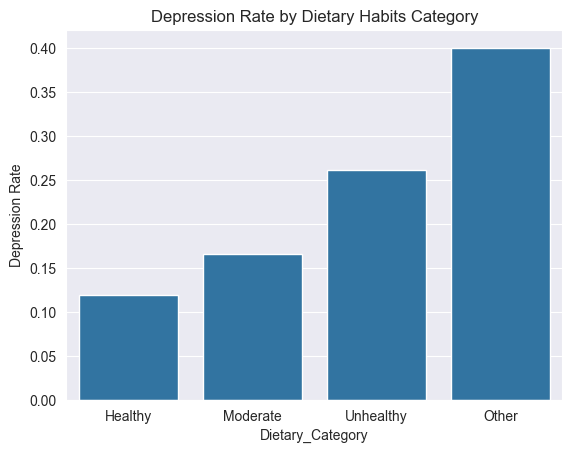

In [41]:
# Get all dietary habits columns
diet_cols = [col for col in train.columns if col.startswith("Dietary Habits_")]

# Calculate depression rate as: (depressed cases in category) / (total in category)
diet_depression = pd.DataFrame({
    "Dietary_Category": [col.replace("Dietary Habits_", "") for col in diet_cols],
    "Depression_Rate": [train[train[col] == 1]["Depression"].mean() for col in diet_cols]
})

# Define logical category order (modify as needed)
category_order = ["Healthy", "Moderate", "Unhealthy", "Other"] 
diet_depression = diet_depression.set_index("Dietary_Category").loc[category_order].reset_index()

sns.barplot(data=diet_depression, x="Dietary_Category", y="Depression_Rate", 
            order=category_order)
plt.title("Depression Rate by Dietary Habits Category")
plt.ylabel("Depression Rate")
plt.show()

### Key Insights 
A bad quality of life have a higher depression rate

## Mutual Information

<Axes: title={'center': 'Mutual Information with Depression'}>

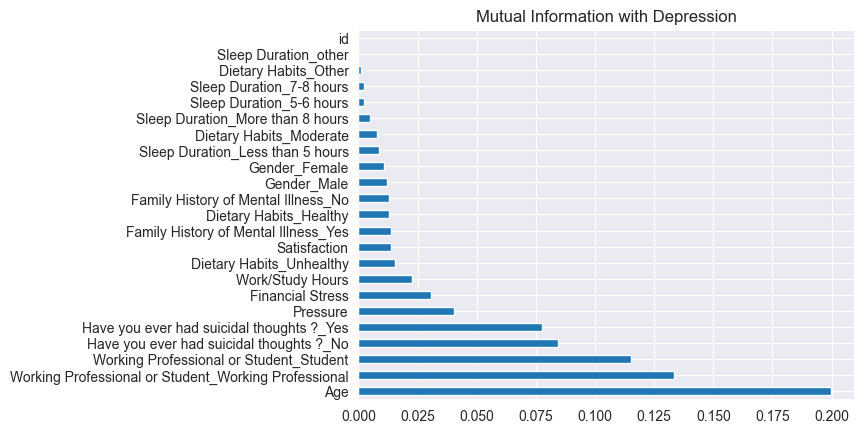

In [ ]:

X_train_mi = X_train.drop(columns="CGPA")
mi = mutual_info_classif(X_train_mi, y_train, random_state=0)
mi_series = pd.Series(mi, index=X_train_mi.columns).sort_values(ascending=False)
mi_series.plot.barh(title="Mutual Information with Depression")

## Strongest Predictors:
- Pressure 
- Satisfaction 
- Financial Stress 
- Work/Study Hours 
- Suicidal thoughts